# ASDF Example

**Use case:** Create ASDF (Advanced Scientific Data Format) file from FITS file.<br>
**Data:** CANDELS image of the COSMOS field.<br>
**Tools:** asdf, gwcs, astrocut.<br>
**Cross-intrument:** all instruments.<br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis).<br>

## Introduction
  
JWST data files make use of the [Advanced Scientific Data Format](https://asdf.readthedocs.io/en/2.5.2/). The ASDF metadata are stored in a FITS extension. The JWST pipline software reads and writes these from the in-memory [datamodels](https://jwst-pipeline.readthedocs.io/en/latest/jwst/datamodels/). 

However, it is relatively straightforward to read and write a pure ASDF file, skipping FITS and datamodels entirely. This notebook illustrates some aspects of ASDF using a FITS file as a starting point.

## Imports
 - astrocut for getting the data via the [astrocut](https://astrocut.readthedocs.io/en/latest/) service at [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html)
 - the fits library from astropy for reading in the FITS file
 - the astropy coordinates `SkyCoord` object for dealing with celestial coordinates
 - matplotlib for making plots
 - asdf and the `AsdfFile` object
 - the astropy `Table` object for a notebook-friendly view of the header
 - Items from the modeling, coordinates and wcs libraries for an example of converting world coordinate system information from FITS keywords to a `gwcs` data structure.

In [1]:
from astrocut import fits_cut
from astropy.io import fits
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import asdf
from asdf import AsdfFile

# For example 4
from astropy.table import Table

# For example 6
from astropy.modeling import models
from astropy import coordinates as coord
from astropy import units as u
from astropy.wcs import WCS
from gwcs.wcstools import wcs_from_fiducial

In [2]:
%matplotlib inline

## Get the data
We'll grab a cutout from the CANDELS observations of COSMOS using astroquery.

In [3]:
url = "https://archive.stsci.edu/pub/hlsp/candels/cosmos/cos-tot/v1.0/"
input_files = [url + "hlsp_candels_hst_acs_cos-tot-sect23_f606w_v1.0_drz.fits"]

In [4]:
center_coord = SkyCoord("150.0946 2.38681", unit='deg')
cutout_size = [100, 100]

In [5]:
cutout_file = fits_cut(input_files, center_coord, cutout_size, single_outfile=True)

In [6]:
print(cutout_file)

cutout_150.0946000_2.3868100_100-x-100_astrocut.fits


## Read in the FITS file, look at its structure and display the data

In [7]:
cutout_hdulist = fits.open(cutout_file)
cutout_hdulist.info()

Filename: cutout_150.0946000_2.3868100_100-x-100_astrocut.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      11   ()      
  1  CUTOUT        1 ImageHDU      2769   (100, 100)   float32   


Pull apart the FITS components, for convenience later on.

In [8]:
data = cutout_hdulist[1].data
header0 = cutout_hdulist[0].header
header1 = cutout_hdulist[1].header

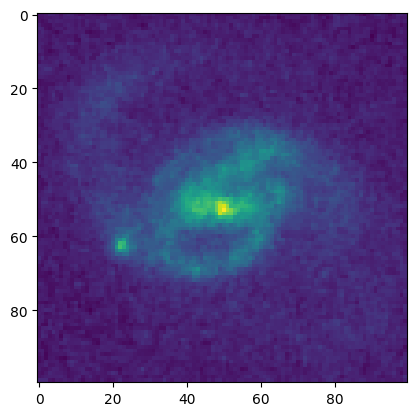

In [9]:
plt.imshow(data)

In [10]:
header1

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100                                                  
NAXIS2  =                  100                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
OBJECT  = 'COS_2EPOCH_ACS_F606W_030MAS_V1.0_SECT23_DRZ[1/1]'                    
ORIGIN  = 'KPNO-IRAF'           /                                               
DATE    = '2012-12-31T17:40:43'                                                 
IRAFNAME= 'cos_2epoch_acs_f606w_030mas_v1.0_sect23_drz.hhh'  /  NAME OF IRAF IMA
IRAF-MAX=           0.000000E0  /  DATA MAX                                     
IRAF-MIN=           0.000000

## Example 1: Store just the key-value pairs of the metadata in ASDF

The basic asdf data structure is a dictionary. The astropy FITS header object acts like a python dictionary. We can copy it into a pure dictionary, which will be useful when we want to add the data.

In [11]:
tree1 = {**header1} 

One more line of code to turn it into asdf. 

In [12]:
myfile = AsdfFile(tree1)

We won't save this to a file yet. First, let's inspect the tree.

In [13]:
myfile.tree

{'XTENSION': 'IMAGE', 'BITPIX': -32, 'NAXIS': 2, 'NAXIS1': 100, 'NAXIS2': 100, 'PCOUNT': 0, 'GCOUNT': 1, 'OBJECT': 'COS_2EPOCH_ACS_F606W_030MAS_V1.0_SECT23_DRZ[1/1]', 'ORIGIN': 'KPNO-IRAF', 'DATE': '2012-12-31T17:40:43', 'IRAFNAME': 'cos_2epoch_acs_f606w_030mas_v1.0_sect23_drz.hhh', 'IRAF-MAX': 0.0, 'IRAF-MIN': 0.0, 'IRAF-BPX': 32, 'IRAFTYPE': 'REAL', 'DATAMIN': 0.0, 'DATAMAX': 0.0, 'CRPIX1': -2552.5, 'CRVAL1': 150.1163213, 'CTYPE1': 'RA---TAN', 'CD1_1': -8.333333e-06, 'CD2_1': 0.0, 'CRPIX2': -22248.5, 'CRVAL2': 2.200973097, 'CTYPE2': 'DEC--TAN', 'CD1_2': 0.0, 'CD2_2': 8.333333e-06, 'FILETYPE': 'SCI', '': 

      / DATA DESCRIPTION KEYWORDS


      / TARGET INFORMATION


      / PROPOSAL INFORMATION


      / EXPOSURE INFORMATION




      / POINTING INFORMATION


      / TARGET OFFSETS (POSTARGS)


      / DIAGNOSTIC KEYWORDS


      / SCIENCE INSTRUMENT CONFIGURATION


      / CALIBRATION SWITCHES: PERFORM, OMIT, COMPLETE


      / CALIBRATION REFERENCE FILES


      / COSMIC RAY REJ

# Example 2: Save the FITS header annotations
The fits header includes comments for many of the keywords. It's a bit clunky, but we can save those by storing a tuple instead of just the value in the dictionary. While we're at it, let's toss some of the FITS keywords that aren't useful.

In [14]:
toss_these = ['XTENSION', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'CHECKSUM',
              'DATASUM', 'EXTNAME', 'FILETYPE', 'PCOUNT', 'GCOUNT',
              'IRAF-BPX', 'IRAF-MIN', 'IRAF-MAX', 'IRAFNAME', 'IRAFTYPE']
annotated_tree = {}
for card in header1.cards:
    if card[0] not in toss_these:
        annotated_tree[card[0]] = (card[1], card[2])

In [15]:
myfile = AsdfFile(annotated_tree)

In [16]:
myfile.tree

{'OBJECT': ('COS_2EPOCH_ACS_F606W_030MAS_V1.0_SECT23_DRZ[1/1]', ''), 'ORIGIN': ('NOAO-IRAF FITS Image Kernel July 2003', 'FITS file originator'), 'DATE': ('2012-04-10T16:39:27', 'Date FITS file was generated'), 'DATAMIN': (0.0, ''), 'DATAMAX': (0.0, ''), 'CRPIX1': (-2552.5, 'Pixel coordinate of reference point'), 'CRVAL1': (150.1163213, '[deg] Coordinate value at reference point'), 'CTYPE1': ('RA---TAN', 'Right ascension, gnomonic projection'), 'CD1_1': (-8.333333e-06, ''), 'CD2_1': (0.0, ''), 'CRPIX2': (-22248.5, 'Pixel coordinate of reference point'), 'CRVAL2': (2.200973097, '[deg] Coordinate value at reference point'), 'CTYPE2': ('DEC--TAN', 'Declination, gnomonic projection'), 'CD1_2': (0.0, ''), 'CD2_2': (8.333333e-06, ''), '': ('', ''), 'TELESCOP': ('HST', 'telescope used to acquire data'), 'INSTRUME': ('ACS', 'identifier for instrument used to acquire data'), 'EQUINOX': (2000.0, '[yr] Equinox of equatorial coordinates'), 'ROOTNAME': ('jboa28wmq', 'rootname of the observation set

The value is now in the first element of each tuple. For example, to get just the value of `CRVAL1`, we could do something like the following.

In [17]:
myfile['CRVAL1'][0]

150.1163213

In [18]:
# Update O_EXT_NM key since it was blank and causing crashing while saving below.

myfile.tree['O_EXT_NM'] = 'Original Name Filler'

## Example 3: View the file as a searchable table

For both FITS and ASDF, it can sometimes be painful to search through a long header. This example shows one way of putting the ASDF file into an Astropy table, and then using the `show_in_notebook` method to provide an interactive tabular view. You can then search by keyword or sort by column (by clicking on the headers).

In this example, we pull apart two-element tuples into values and comments. For the other data structures, we just put them into the comment column.

In [19]:
def tree_to_table(tree):
    keys = list(tree.keys())
    values, other = ([] for i in range(2))
    for k in keys:
        try:
            values += [tree[k][0]]
            other += [tree[k][1]]
        except Exception as e:
            values += [None]
            other += [tree[k]]
            print("An error occured ", e)
    return Table([keys, values, other], names=['key', 'value', 'comment or data structure'])

In [20]:
t = tree_to_table(myfile.tree)
t.show_in_notebook()

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

## Example 4: Add the data and write to a file
So that's the header. Now we just need to add the data to the dictionary. We can use any descriptive key we like. Maybe we should call it `data`.

In [21]:
myfile['data'] = data # Equivalent to myfile.tree['data'] = data

In [22]:
myfile['data']

array([[-6.6392368e-04, -7.4554735e-04,  4.8087438e-04, ...,
         5.0681373e-03,  3.0521965e-03,  1.8753707e-03],
       [-2.0862564e-03, -1.8097271e-03,  2.6454803e-05, ...,
         3.0450651e-03, -9.7416568e-04,  2.4262909e-04],
       [-1.3179937e-03, -3.5285766e-03, -1.8192229e-03, ...,
         3.1758491e-03,  1.6773099e-04,  2.3124062e-03],
       ...,
       [-1.9475160e-03, -3.0709282e-03,  9.3518662e-05, ...,
         1.3050702e-03, -3.7302810e-03,  9.8174601e-04],
       [-1.1018811e-03,  5.1750882e-05,  2.0913549e-03, ...,
         1.2541392e-03,  1.9218342e-03,  8.1874104e-03],
       [ 6.1663929e-03,  6.2804343e-03,  5.8753230e-03, ...,
         1.7368054e-03, -2.3874418e-04,  3.9537032e-03]],
      shape=(100, 100), dtype='>f4')

In [23]:
type(myfile)
myfile.info()

root (AsdfObject)
├─OBJECT (tuple) ...
├─ORIGIN (tuple) ...
├─DATE (tuple) ...
├─DATAMIN (tuple) ...
├─DATAMAX (tuple) ...
├─CRPIX1 (tuple) ...
├─CRVAL1 (tuple) ...
├─CTYPE1 (tuple) ...
├─CD1_1 (tuple) ...
├─CD2_1 (tuple) ...
├─CRPIX2 (tuple) ...
├─CRVAL2 (tuple) ...
├─CTYPE2 (tuple) ...
├─CD1_2 (tuple) ...
├─CD2_2 (tuple) ...
├─ (tuple) ...
├─TELESCOP (tuple) ...
├─INSTRUME (tuple) ...
├─EQUINOX (tuple) ...
├─ROOTNAME (tuple) ...
├─IMAGETYP (tuple) ...
└─2653 not shown
Some nodes not shown.


In [24]:
myfile.write_to('myfile.asdf')

Read the asdf file from disk and look at the tree and the data

In [25]:
ff = asdf.open('myfile.asdf')
ff.tree

{'asdf_library': {'author': 'The ASDF Developers', 'homepage': 'http://github.com/asdf-format/asdf', 'name': 'asdf', 'version': '4.2.0'}, 'history': {'extensions': [{'extension_class': 'asdf.extension._manifest.ManifestExtension', 'extension_uri': 'asdf://asdf-format.org/core/extensions/core-1.6.0', 'manifest_software': {'name': 'asdf_standard', 'version': '1.3.0'}, 'software': {'name': 'asdf', 'version': '4.2.0'}}]}, '': ['', ''], 'APERTURE': ['WFC', 'aperture name'], 'ASN_ID': ['JBOA28010', 'unique identifier assigned to association'], 'ASN_MTYP': ['EXP-DTH', 'Role of the Member in the Association'], 'ASN_TAB': ['jboa28010_asn.fits', 'name of the association table'], 'ATODCORR': ['OMIT', 'correct for A to D conversion errors'], 'ATODGNA': [2.02, 'calibrated gain for amplifier A'], 'ATODGNB': [1.886, 'calibrated gain for amplifier B'], 'ATODGNC': [2.017, 'calibrated gain for amplifier C'], 'ATODGND': [2.0109999, 'calibrated gain for amplifier D'], 'ATODTAB': ['jref$t3n1116mj_a2d.fits'

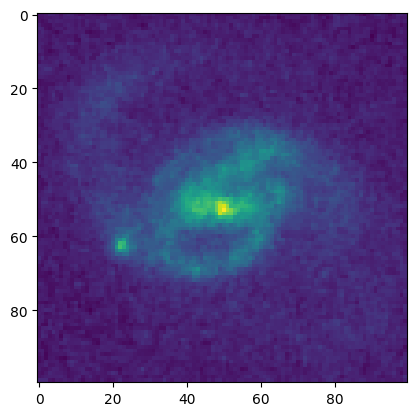

In [26]:
plt.imshow(ff['data'])

## Example 5: Storing multiple extensions
The perspicacious reader will have noticed that the previous examples only dealt with extension 1 of the FITS file, leaving the primary header out of the ASDF file. There is no prescribed way to arrange the multiple extensions of a FITS file into an ASDF file. One option would be to create a separate dictionary for each extension and then make a dictionary of these, e.g.:

``` 
    ext1, ext2 = dict(**header0), dict(**header1)
    tree = {'ext1':ext1, 'ext2':ext2}
```

In this case, that would be a bit silly, because the only information of potential value in the ASDF file might be the `ORIGIN, DATE, PROC_VER, RA_OBJ` and `DEC_OBJ`. However, looking at the extension, there is an `ORIGIN` there that will conflict with the `ORIGIN`. (Somewhat amusingly, they have different meanings, according to the comments.)

In [27]:
header0

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
ORIGIN  = 'STScI/MAST'         / institution responsible for creating this file 
DATE    = '2025-06-30'         / file creation date                             
PROCVER = '1.0.1   '           / software version                               
RA_OBJ  =             150.0946 / [deg] right ascension                          
DEC_OBJ =              2.38681 / [deg] declination                              
CHECKSUM= 'Xm9GXj69Xj6GXj69'   / HDU checksum updated 2025-06-30T19:21:56       
DATASUM = '0       '           / data unit checksum updated 2025-06-30T19:21:56 

One solution to the naming conflict might be to stuff this extra information into its own namespace, as a sub-item of the original dictionary.

In [28]:
keywords = ['ORIGIN', 'DATE', 'PROCVER', 'RA_OBJ', 'DEC_OBJ']
primary_header = {}
for card in header0.cards:
    if card[0] in keywords:
        primary_header[card[0]] = (card[1], card[2])
ff.tree['primary_header'] = primary_header
ff.tree

{'asdf_library': {'author': 'The ASDF Developers', 'homepage': 'http://github.com/asdf-format/asdf', 'name': 'asdf', 'version': '4.2.0'}, 'history': {'extensions': [{'extension_class': 'asdf.extension._manifest.ManifestExtension', 'extension_uri': 'asdf://asdf-format.org/core/extensions/core-1.6.0', 'manifest_software': {'name': 'asdf_standard', 'version': '1.3.0'}, 'software': {'name': 'asdf', 'version': '4.2.0'}}]}, '': ['', ''], 'APERTURE': ['WFC', 'aperture name'], 'ASN_ID': ['JBOA28010', 'unique identifier assigned to association'], 'ASN_MTYP': ['EXP-DTH', 'Role of the Member in the Association'], 'ASN_TAB': ['jboa28010_asn.fits', 'name of the association table'], 'ATODCORR': ['OMIT', 'correct for A to D conversion errors'], 'ATODGNA': [2.02, 'calibrated gain for amplifier A'], 'ATODGNB': [1.886, 'calibrated gain for amplifier B'], 'ATODGNC': [2.017, 'calibrated gain for amplifier C'], 'ATODGND': [2.0109999, 'calibrated gain for amplifier D'], 'ATODTAB': ['jref$t3n1116mj_a2d.fits'

## Example 6: Converting from FITS WCS keywords to a gwcs object
This is a bit complicated, and not particularly advantageous for this example. 

The generalized world-coordinate system, [gwcs](https://gwcs.readthedocs.io) package is built to support complex mappings between detector coordinates and coordinates. In this case it's overkill. But it does illustrate saving a complex data object to an `asdf` file. The `gwcs` package extends asdf to specify the `wcs` object. In doing so, it makes extensive use of the transforms that are defined in the [asdf standard](https://asdf-standard.readthedocs.io/en/latest/). 

This example follows the instructions in the [gwcs documentation](https://gwcs.readthedocs.io/en/latest/#a-step-by-step-example-of-constructing-an-imaging-gwcs-object). There is no rotation in this example, so we can follow the [example](https://gwcs.readthedocs.io/en/latest/gwcs/wcstools.html) that makes use of convenience function `wcs_from_fiducial`.

Down the road there should be some convenience methods for converting common FITS WCSs and dealing gracefully with the (unfortunately quite common) inconsistencies.

For convenience, let's use and astropy wcs object to grab the world-coordinate system information. This particular example reveals a problem that is quite common in FITS files: redundant and potentially inconsistent WCS information. In this case, the file is using both the PC matrix approach and the CD matrix approach. We'll take the PC matrix as "truth". 

In [29]:
fitswcs = WCS(header1)
print(fitswcs)

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
WCS Keywords

Number

/usr/share/miniconda/lib/python3.13/site-packages/astropy/wcs/wcs.py:3118: RuntimeWarning: cdelt will be ignored since cd is present
  description.append(s.format(*self.wcs.cdelt))


Grab some values from the wcs for improved readability of cells further down

In [30]:
crval1, crval2 = fitswcs.wcs.crval
cunit1, cunit2 = [u.Unit(cu) for cu in fitswcs.wcs.cunit]
pcmatrix = fitswcs.wcs.pc
cunit1, cunit2

(Unit("deg"), Unit("deg"))

To create a WCS from a pointing on the sky, as a minimum pass a sky coordinate and a projection to the function.

In [31]:
fiducial = coord.SkyCoord(crval1*cunit1, crval2*cunit2, frame='icrs')
tan = models.Pix2Sky_TAN()

Create a pipeline for the coordinate transformations. In this case apply a shift and then a rescaling. The function `wcs_from_fiducial` prepends these onto the sky projection.

In [32]:
trans = models.Shift(-crval1) & models.Shift(-crval2) |\
        models.Scale(-pcmatrix[0, 0]) & models.Scale(pcmatrix[1, 1])

In [33]:
wcsobj = wcs_from_fiducial(fiducial, projection=tan, transform=trans)
wcsobj

<WCS(output_frame=CelestialFrame, input_frame=None, forward_transform=Model: CompoundModel
Inputs: ('x0', 'x1')
Outputs: ('alpha_C', 'delta_C')
Model set size: 1
Expression: [0] & [1] | [2] & [3] | [4] | [5]
Components: 
    [0]: <Shift(offset=-150.1163213)>

    [1]: <Shift(offset=-2.2009731)>

    [2]: <Scale(factor=0.00000833)>

    [3]: <Scale(factor=0.00000833)>

    [4]: <Pix2Sky_Gnomonic()>

    [5]: <RotateNative2Celestial(lon=150.1163213 deg, lat=2.2009731 deg, lon_pole=180. deg)>
Parameters:
      offset_0     offset_1     factor_2   ...    lon_5       lat_5    lon_pole_5
                                           ...     deg         deg        deg    
    ------------ ------------ ------------ ... ----------- ----------- ----------
    -150.1163213 -2.200973097 8.333333e-06 ... 150.1163213 2.200973097      180.0)>

Get rid of the now obsolete FITS WCS keywords from the ASDF header. It's blissfully short, and one could argue devoid of almost anything useful. 

In [34]:
fits_wcs_keywords = [
    'CRPIX1', 'CRVAL1', 'CTYPE1', 'CD1_1', 'CD2_1', 'CRPIX2', 'CRVAL2', 
    'CTYPE2', 'CD1_2', 'CD2_2', 'WCSAXES', 'PC1_1', 'PC2_2', 'CDELT1', 
    'CDELT2', 'CUNIT1', 'CUNIT2', 'LONPOLE', 'LATPOLE', 'RADESYS']
[ff.tree.pop(old_kw, None) for old_kw in fits_wcs_keywords]

[[-2552.5, 'Pixel coordinate of reference point'],
 [150.1163213, '[deg] Coordinate value at reference point'],
 ['RA---TAN', 'Right ascension, gnomonic projection'],
 [-8.333333e-06, ''],
 [0.0, ''],
 [-22248.5, 'Pixel coordinate of reference point'],
 [2.200973097, '[deg] Coordinate value at reference point'],
 ['DEC--TAN', 'Declination, gnomonic projection'],
 [0.0, ''],
 [8.333333e-06, ''],
 [2, 'Number of coordinate axes'],
 [-8.333333e-06, 'Coordinate transformation matrix element'],
 [8.333333e-06, 'Coordinate transformation matrix element'],
 [1.0, '[deg] Coordinate increment at reference point'],
 [1.0, '[deg] Coordinate increment at reference point'],
 ['deg', 'Units of coordinate increment and value'],
 ['deg', 'Units of coordinate increment and value'],
 [180.0, '[deg] Native longitude of celestial pole'],
 [2.200973097, '[deg] Native latitude of celestial pole'],
 ['FK5', 'Equatorial coordinate system']]

Add the wcs object to the tree. The `gwcs` package takes care of the machinery for serializing this object to ASDF. 

In [35]:
ff.tree['wcs'] = wcsobj

In [36]:
t = tree_to_table(ff.tree)
t.show_in_notebook()

An error occured  0
An error occured  0
An error occured  0
An error occured  'WCS' object is not subscriptable


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…